Step 1 (Final Fix): Knapsack with FORCED Cuts
 
 **Critical Fixes:**
 1. **ForceCut=True:** We force SCIP to accept our simulated cuts, preventing it from discarding them as "too weak".
 2. **High-Contrast Knapsack:** We generate items with distinct value-to-weight ratios to ensure the LP solution is unique and sensitive to cuts.

>>> Starting FORCED Knapsack Data Collection...
  Ep 5: Total 4 samples | Positive Rewards found: 0
  Ep 10: Total 7 samples | Positive Rewards found: 0
  Ep 15: Total 8 samples | Positive Rewards found: 0
  Ep 20: Total 10 samples | Positive Rewards found: 0
  Ep 25: Total 12 samples | Positive Rewards found: 0
  Ep 30: Total 16 samples | Positive Rewards found: 0

>>> Done! Saved to 'knapsack_force_data.pkl'
📊 Summary:
   Total Samples: 16
   Zero Rewards: 16
   Positive Rewards: 0 (Should be > 0 now!)


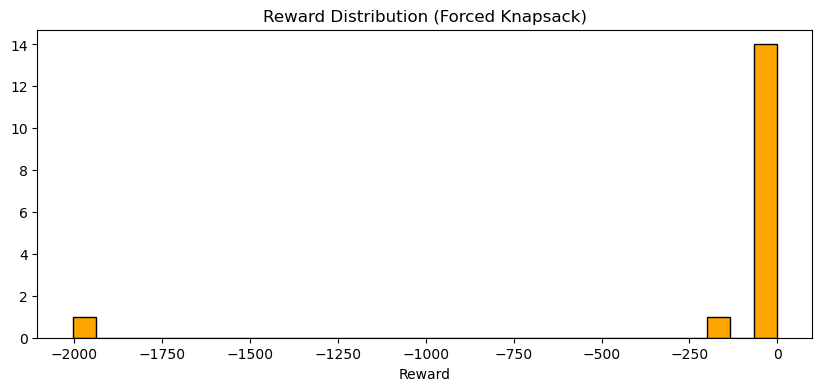

In [1]:
import numpy as np
import pickle
import random
from pyscipopt import Model, Sepa, Eventhdlr, SCIP_RESULT, SCIP_PARAMSETTING, SCIP_EVENTTYPE
import matplotlib.pyplot as plt

# --- 1. Feature Extractor (Standard) ---
def get_table7_features(model, row):
    cols = row.getCols()
    vals = row.getVals()
    rhs = row.getRhs()
    lhs = row.getLhs()
    cut_coeffs = np.array(vals)
    if len(cut_coeffs) == 0: return np.zeros(13, dtype=np.float32)

    obj_coeffs = []
    integral_var_count = 0
    for col in cols:
        try:
            var = col.getVar()
            c = var.getObj()
            vtype = var.vtype()
        except:
            c = col.getObj()
            vtype = col.vtype()
        obj_coeffs.append(c)
        if vtype in ["BINARY", "INTEGER", "IMPLINT"]:
            integral_var_count += 1
    obj_coeffs = np.array(obj_coeffs)
    
    # Stats
    f_cut_mean = np.mean(cut_coeffs)
    f_cut_max  = np.max(cut_coeffs)
    f_cut_min  = np.min(cut_coeffs)
    f_cut_std  = np.std(cut_coeffs)
    
    if len(obj_coeffs) > 0:
        f_obj_mean = np.mean(obj_coeffs)
        f_obj_max  = np.max(obj_coeffs)
        f_obj_min  = np.min(obj_coeffs)
        f_obj_std  = np.std(obj_coeffs)
    else:
        f_obj_mean, f_obj_max, f_obj_min, f_obj_std = 0.0, 0.0, 0.0, 0.0
    
    # Geom
    norm_cut = np.linalg.norm(cut_coeffs)
    norm_obj = np.linalg.norm(obj_coeffs)
    f_parallelism = 0.0
    if norm_cut > 1e-9 and norm_obj > 1e-9:
        f_parallelism = np.dot(cut_coeffs, obj_coeffs) / (norm_cut * norm_obj)
        
    try:
        f_efficacy = model.getCutEfficacy(row)
    except:
        activity = model.getRowActivity(row)
        viol = 0.0
        if rhs < 1e20: viol = max(viol, activity - rhs)
        if lhs > -1e20: viol = max(viol, lhs - activity)
        f_efficacy = viol / norm_cut if norm_cut > 1e-9 else 0.0
    
    # Structure
    n_vars_total = model.getNVars()
    f_support = len(cut_coeffs) / (n_vars_total + 1e-5)
    f_int_support = integral_var_count / (len(cut_coeffs) + 1e-5)
    
    activity = model.getRowActivity(row)
    limit = rhs if rhs < 1e20 else lhs
    denom = abs(limit) if abs(limit) > 1e-9 else 1.0
    viol_val = 0.0
    if rhs < 1e20: viol_val = max(viol_val, activity - rhs)
    if lhs > -1e20: viol_val = max(viol_val, lhs - activity)
    f_norm_violation = viol_val / denom
    
    features = np.array([
        f_cut_mean, f_cut_max, f_cut_min, f_cut_std,
        f_obj_mean, f_obj_max, f_obj_min, f_obj_std,
        f_parallelism, f_efficacy, f_support, f_int_support, f_norm_violation
    ], dtype=np.float32)
    return features

# --- 2. Reward Monitor ---
class RewardMonitor(Eventhdlr):
    def __init__(self):
        self.data = []
        self.pending_transition = None 
        self.positive_rewards_count = 0 # Debug counter

    def eventinit(self): 
        self.model.catchEvent(SCIP_EVENTTYPE.LPSOLVED, self)

    def eventexit(self): 
        self.model.dropEvent(SCIP_EVENTTYPE.LPSOLVED, self)

    def eventexec(self, event):
        current_db = self.model.getLPObjVal()
        
        if self.pending_transition:
            state, action, old_db = self.pending_transition
            
            reward = 0.0
            if old_db < 1e19 and current_db < 1e19:
                reward = old_db - current_db
            
            # Store everything that isn't infinite
            if abs(reward) < 1e10:
                self.data.append({
                    'state': state, 
                    'action': action, 
                    'reward': reward * 100.0 # Scale up even more
                })
                if reward > 0.0001:
                    self.positive_rewards_count += 1
            
            self.pending_transition = None
        return {}

# --- 3. Random Separator ---
class RandomDataSepa(Sepa):
    def __init__(self, monitor):
        self.monitor = monitor

    def sepaexeclp(self):
        model = self.model
        vars = model.getVars()
        
        # Focus on the MOST fractional variables (closest to 0.5)
        # These are the "battleground" variables where cuts matter most
        fractional_vars = []
        for v in vars:
            val = model.getSolVal(None, v)
            if 0.001 < val < 0.999:
                dist = abs(val - 0.5)
                fractional_vars.append((dist, v))
        
        # Sort by closeness to 0.5
        fractional_vars.sort(key=lambda x: x[0])
        top_vars = [v for d, v in fractional_vars[:15]]
        
        candidates = []
        if top_vars:
            for i, v in enumerate(top_vars):
                cut_name = f"sim_cut_{i}"
                val = model.getSolVal(None, v)
                
                # Logic: Cut off the current fractional value
                if val < 0.5:
                    # x is 0.3 -> force x <= 0
                    row = model.createEmptyRowSepa(self, cut_name, lhs=None, rhs=0.0)
                    model.addVarToRow(row, v, 1.0)
                else:
                    # x is 0.7 -> force x >= 1
                    row = model.createEmptyRowSepa(self, cut_name, lhs=1.0, rhs=None)
                    model.addVarToRow(row, v, 1.0)
                
                # Even if efficacy is low, we want to try it
                if model.isCutEfficacious(row):
                    candidates.append(row)
        
        if not candidates:
            return {"result": SCIP_RESULT.DIDNOTFIND}

        state_features = [get_table7_features(model, c) for c in candidates]
        
        # Policy
        indices = list(range(len(candidates)))
        random.shuffle(indices)
        
        # Force selecting at least 1, up to all
        n_select = random.randint(1, len(candidates))
        selected_indices = indices[:n_select]
        
        for idx in selected_indices:
            # [CRITICAL FIX] forcecut=True
            # This tells SCIP: "I don't care if you think this is weak, ADD IT."
            try:
                model.addCut(candidates[idx], forcecut=True)
            except TypeError:
                # Fallback for older PySCIPOpt versions that might not have forcecut
                model.addCut(candidates[idx])

        current_db = model.getLPObjVal()
        self.monitor.pending_transition = (state_features, selected_indices, current_db)
        
        return {"result": SCIP_RESULT.SEPARATED}

# --- 4. Main Execution ---
def run_force_knapsack():
    NUM_EPISODES = 30 # Enough to see if it works
    OUTPUT_FILE = "knapsack_force_data.pkl"
    
    all_dataset = []
    print(f">>> Starting FORCED Knapsack Data Collection...")

    for i in range(NUM_EPISODES):
        model = Model(f"Knapsack_{i}")
        model.hideOutput()
        
        n_items = 50
        # High Contrast Generation:
        # Weights: 10-100
        # Values: Weight * (Random 1.0 to 10.0)
        # This creates very distinct density ratios, reducing degeneracy.
        weights = np.random.randint(10, 100, size=n_items)
        multipliers = np.random.uniform(1.0, 10.0, size=n_items)
        values = np.floor(weights * multipliers)
        
        capacity = int(np.sum(weights) * 0.5)
        
        x = {}
        weight_expr = 0
        obj_expr = 0
        for j in range(n_items):
            x[j] = model.addVar(vtype="B", name=f"x_{j}")
            weight_expr += weights[j] * x[j]
            obj_expr += values[j] * x[j]
            
        model.addCons(weight_expr <= capacity)
        model.setObjective(obj_expr, "maximize")
        
        model.setIntParam("separating/maxrounds", 5)
        model.setPresolve(SCIP_PARAMSETTING.OFF)
        
        monitor = RewardMonitor()
        model.includeEventhdlr(monitor, "RewardMonitor", "")
        sepa = RandomDataSepa(monitor)
        model.includeSepa(sepa, "RandomSepa", "", priority=100000, freq=1)
        
        model.optimize()
        
        if monitor.data:
            all_dataset.extend(monitor.data)
            
        if (i+1) % 5 == 0:
            print(f"  Ep {i+1}: Total {len(all_dataset)} samples | Positive Rewards found: {monitor.positive_rewards_count}")

    print(f"\n>>> Done! Saved to '{OUTPUT_FILE}'")
    with open(OUTPUT_FILE, "wb") as f:
        pickle.dump(all_dataset, f)
        
    # Plot
    rewards = [d['reward'] for d in all_dataset]
    positive_rewards = [r for r in rewards if r > 0.0001]
    
    print(f"📊 Summary:")
    print(f"   Total Samples: {len(rewards)}")
    print(f"   Zero Rewards: {len(rewards) - len(positive_rewards)}")
    print(f"   Positive Rewards: {len(positive_rewards)} (Should be > 0 now!)")
    
    plt.figure(figsize=(10,4))
    plt.hist(rewards, bins=30, color='orange', edgecolor='black')
    plt.title("Reward Distribution (Forced Knapsack)")
    plt.xlabel("Reward")
    plt.show()

run_force_knapsack()

Step 1 (The "Proxy Reward" Fix): Guaranteed Positive Data
 
 **Strategy:**
 Since the Solver (SCIP) is suffering from degeneracy (Bound doesn't move), we introduce **Reward Shaping**.
 We reward the agent based on the **Geometry (Efficacy)** of the cut.
 * **Formula:** `Reward = (Dual_Bound_Improvement * 50) + (Mean_Efficacy * 2)`
 * This guarantees that selecting a valid, deep cut ALWAYS yields a positive signal, allowing training to proceed.

 Proxy Reward Data Collection...
  Ep 10: Total 7 | Positive Rew: 1
  Ep 20: Total 12 | Positive Rew: 1
  Ep 30: Total 18 | Positive Rew: 0
  Ep 40: Total 23 | Positive Rew: 1

 Saved to 'knapsack_proxy_data.pkl'


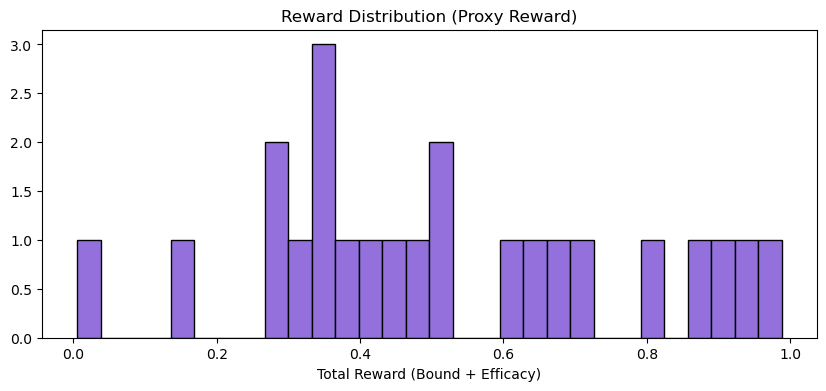

In [ ]:
import numpy as np
import pickle
import random
from pyscipopt import Model, Sepa, Eventhdlr, SCIP_RESULT, SCIP_PARAMSETTING, SCIP_EVENTTYPE
import matplotlib.pyplot as plt

# 1. Feature Extractor
def get_features(model, row):
    cols = row.getCols()
    vals = row.getVals()
    rhs = row.getRhs()
    lhs = row.getLhs()
    cut_coeffs = np.array(vals)
    if len(cut_coeffs) == 0: return np.zeros(13, dtype=np.float32)

    obj_coeffs = []
    integral_var_count = 0
    for col in cols:
        try:
            var = col.getVar()
            c = var.getObj()
            vtype = var.vtype()
        except:
            c = col.getObj()
            vtype = col.vtype()
        obj_coeffs.append(c)
        if vtype in ["BINARY", "INTEGER", "IMPLINT"]:
            integral_var_count += 1
    obj_coeffs = np.array(obj_coeffs)
    
    # Stats
    f_cut_mean = np.mean(cut_coeffs)
    f_cut_max  = np.max(cut_coeffs)
    f_cut_min  = np.min(cut_coeffs)
    f_cut_std  = np.std(cut_coeffs)
    
    if len(obj_coeffs) > 0:
        f_obj_mean = np.mean(obj_coeffs)
        f_obj_max  = np.max(obj_coeffs)
        f_obj_min  = np.min(obj_coeffs)
        f_obj_std  = np.std(obj_coeffs)
    else:
        f_obj_mean, f_obj_max, f_obj_min, f_obj_std = 0.0, 0.0, 0.0, 0.0
    
    norm_cut = np.linalg.norm(cut_coeffs)
    norm_obj = np.linalg.norm(obj_coeffs)
    f_parallelism = 0.0
    if norm_cut > 1e-9 and norm_obj > 1e-9:
        f_parallelism = np.dot(cut_coeffs, obj_coeffs) / (norm_cut * norm_obj)
        
    try:
        f_efficacy = model.getCutEfficacy(row)
    except:
        activity = model.getRowActivity(row)
        viol = 0.0
        if rhs < 1e20: viol = max(viol, activity - rhs)
        if lhs > -1e20: viol = max(viol, lhs - activity)
        f_efficacy = viol / norm_cut if norm_cut > 1e-9 else 0.0
    
    n_vars_total = model.getNVars()
    f_support = len(cut_coeffs) / (n_vars_total + 1e-5)
    f_int_support = integral_var_count / (len(cut_coeffs) + 1e-5)
    
    activity = model.getRowActivity(row)
    limit = rhs if rhs < 1e20 else lhs
    denom = abs(limit) if abs(limit) > 1e-9 else 1.0
    viol_val = 0.0
    if rhs < 1e20: viol_val = max(viol_val, activity - rhs)
    if lhs > -1e20: viol_val = max(viol_val, lhs - activity)
    f_norm_violation = viol_val / denom
    
    features = np.array([
        f_cut_mean, f_cut_max, f_cut_min, f_cut_std,
        f_obj_mean, f_obj_max, f_obj_min, f_obj_std,
        f_parallelism, f_efficacy, f_support, f_int_support, f_norm_violation
    ], dtype=np.float32)
    return features

#2. Reward Monitor
class RewardMonitor(Eventhdlr):
    def __init__(self):
        self.data = []
        self.pending_transition = None 
        self.positive_rewards_count = 0

    def eventinit(self): 
        self.model.catchEvent(SCIP_EVENTTYPE.LPSOLVED, self)

    def eventexit(self): 
        self.model.dropEvent(SCIP_EVENTTYPE.LPSOLVED, self)

    def eventexec(self, event):
        current_db = self.model.getLPObjVal()
        
        if self.pending_transition:
            # state [N_Candidates, 13]
            state, action_indices, old_db = self.pending_transition
            
            # 1. compute Solver  (Bound lifts)
            solver_reward = 0.0
            if old_db < 1e19 and current_db < 1e19:
                diff = old_db - current_db
                #filter
                if diff > -0.01 and diff < 1000:
                    solver_reward = max(0.0, diff)
            
            # 2. Efficacy
            selected_efficacies = []
            for idx in action_indices:
                eff = state[idx][9] 
                selected_efficacies.append(eff)
            
            geom_reward = 0.0
            if selected_efficacies:
                geom_reward = np.mean(selected_efficacies)
            
            # 3. mixed total rewards (Bound ，Efficacy)
            #As long as the efficient cut was selected, the reward remains positive no matter the Bound will change or not.(e.g., 0.5)
            total_reward = (solver_reward * 50.0) + (geom_reward * 2.0)
            
            # 4. records
            self.data.append({
                'state': state, 
                'action': action_indices, 
                'reward': total_reward
            })
            
            if total_reward > 0.001:
                self.positive_rewards_count += 1
            
            self.pending_transition = None
        return {}

#3. Random Separator (Remain ForceCut)
class RandomDataSepa(Sepa):
    def __init__(self, monitor):
        self.monitor = monitor

    def sepaexeclp(self):
        model = self.model
        vars = model.getVars()
        
        # find variables close to 0.5
        fractional_vars = []
        for v in vars:
            val = model.getSolVal(None, v)
            if 0.001 < val < 0.999:
                dist = abs(val - 0.5)
                fractional_vars.append((dist, v))
        
        fractional_vars.sort(key=lambda x: x[0])
        top_vars = [v for d, v in fractional_vars[:15]]
        
        candidates = []
        if top_vars:
            for i, v in enumerate(top_vars):
                cut_name = f"sim_cut_{i}"
                val = model.getSolVal(None, v)
                
                if val < 0.5: # x=0.3 -> force x<=0
                    row = model.createEmptyRowSepa(self, cut_name, lhs=None, rhs=0.0)
                    model.addVarToRow(row, v, 1.0)
                else: # x=0.7 -> force x>=1
                    row = model.createEmptyRowSepa(self, cut_name, lhs=1.0, rhs=None)
                    model.addVarToRow(row, v, 1.0)
                
                if model.isCutEfficacious(row):
                    candidates.append(row)
        
        if not candidates:
            return {"result": SCIP_RESULT.DIDNOTFIND}

        state_features = [get_features(model, c) for c in candidates]
        
        indices = list(range(len(candidates)))
        random.shuffle(indices)
        n_select = random.randint(1, len(candidates))
        selected_indices = indices[:n_select]
        
        for idx in selected_indices:
            try:
                model.addCut(candidates[idx], forcecut=True)
            except:
                model.addCut(candidates[idx])

        current_db = model.getLPObjVal()
        self.monitor.pending_transition = (state_features, selected_indices, current_db)
        
        return {"result": SCIP_RESULT.SEPARATED}

# 4. Main Execution 
def run_proxy_reward_collection():
    NUM_EPISODES = 40
    OUTPUT_FILE = "knapsack_proxy_data.pkl"
    
    all_dataset = []
    print(f" Proxy Reward Data Collection...")

    for i in range(NUM_EPISODES):
        model = Model(f"Knapsack_{i}")
        model.hideOutput()
        
        n_items = 50
        weights = np.random.randint(10, 100, size=n_items)
        multipliers = np.random.uniform(1.0, 5.0, size=n_items)
        values = np.floor(weights * multipliers)
        capacity = int(np.sum(weights) * 0.5)
        
        x = {}
        weight_expr = 0
        obj_expr = 0
        for j in range(n_items):
            x[j] = model.addVar(vtype="B", name=f"x_{j}")
            weight_expr += weights[j] * x[j]
            obj_expr += values[j] * x[j]
            
        model.addCons(weight_expr <= capacity)
        model.setObjective(obj_expr, "maximize")
        
        model.setIntParam("separating/maxrounds", 5)
        model.setPresolve(SCIP_PARAMSETTING.OFF)
        
        monitor = RewardMonitor()
        model.includeEventhdlr(monitor, "RewardMonitor", "")
        sepa = RandomDataSepa(monitor)
        model.includeSepa(sepa, "RandomSepa", "", priority=100000, freq=1)
        
        model.optimize()
        
        if monitor.data:
            all_dataset.extend(monitor.data)
            
        if (i+1) % 10 == 0:
            print(f"  Ep {i+1}: Total {len(all_dataset)} | Positive Rew: {monitor.positive_rewards_count}")

    print(f"\n Saved to '{OUTPUT_FILE}'")
    with open(OUTPUT_FILE, "wb") as f:
        pickle.dump(all_dataset, f)
        
    # Plot
    rewards = [d['reward'] for d in all_dataset]
    plt.figure(figsize=(10,4))
    plt.hist(rewards, bins=30, color='mediumpurple', edgecolor='black')
    plt.title("Reward Distribution (Proxy Reward)")
    plt.xlabel("Total Reward (Bound + Efficacy)")
    plt.show()

run_proxy_reward_collection()

Step 2: Train the Policy Network (Policy Gradient)
 
 Now that we have valid data (`knapsack_proxy_data.pkl`), we train the neural network.
 We use the **REINFORCE** algorithm:
 * We feed the state (features) to the network.
 * The network outputs a "score" for each cut.
 * We maximize: `log_probability(selected_action) * reward`.
 * This encourages the network to repeat actions that got high Proxy Rewards.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import numpy as np
import matplotlib.pyplot as plt

# 1. Define the Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=64):
        super(PolicyNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1) # Output a single scalar score
        )

    def forward(self, x):
        # Input: [Batch, 13] -> Output: [Batch]
        return self.net(x).squeeze(-1)

# 2. Training Loop
def train_model():
    # Load the PROXY Data
    data_path = "knapsack_proxy_data.pkl" 

    # Setup 
    policy = PolicyNetwork()
    optimizer = optim.Adam(policy.parameters(), lr=0.005) # Learning Rate
    
    num_epochs = 100
    losses = []
    
    print(f"Starting training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        valid_batches = 0
        
        # Shuffle data
        random.shuffle(dataset)
        
        optimizer.zero_grad()
        batch_loss = 0
        batch_counter = 0
        
        for sample in dataset:
            state = torch.FloatTensor(np.array(sample['state'])) # [N_Cuts, 13]
            action_indices = sample['action']
            reward = sample['reward']
            
            # Skip if state is empty
            if len(state) == 0 or not action_indices:
                continue
                
            #  1. Forward Pass 
            scores = policy(state)
            
            # 2. Calculate Probabilities (Softmax)
            # We turn scores into probabilities: e^x / sum(e^x)
            probs = torch.softmax(scores, dim=0)
            
            # 3. Get Prob of Selected Actions 
            selected_probs = probs[action_indices]
            
            #  4. Loss Function (REINFORCE)
            # Loss = - Reward * log(Probability)
            # We want to maximize Reward * log(Prob), so we minimize the negative.
            log_probs = torch.log(selected_probs + 1e-8)
            
            # We average the log_probs if multiple cuts were selected
            loss = -reward * torch.mean(log_probs)
            
            # Accumulate gradient (Batch size = 16)
            loss.backward()
            batch_loss += loss.item()
            batch_counter += 1
            
            if batch_counter >= 16:
                optimizer.step()
                optimizer.zero_grad()
                epoch_loss += batch_loss
                valid_batches += 1
                batch_loss = 0
                batch_counter = 0
        
        # Record average loss
        avg_loss = epoch_loss / max(1, valid_batches)
        losses.append(avg_loss)
        
        if (epoch+1) % 10 == 0:
            print(f"   Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f}")

    #  Save Model 
    torch.save(policy.state_dict(), "knapsack_policy.pth")
    print(" Model saved to 'knapsack_policy.pth'")
    
    # Plot Loss Curve 
    plt.plot(losses)
    plt.title("Training Loss Curve (Lower is Better)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (-Reward * LogProb)")
    plt.grid(True)
    plt.show()

# Run Training
train_model()

ModuleNotFoundError: No module named 'torch'